## Effects of noise
* Effects of noise in a normal recall scenario
* Effects of noise in the weights to the recall time.
* Effects of noise in sequence length?

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect
from plotting_functions import plot_weight_matrix, plot_state_variables_vs_time, plot_winning_pattern
from plotting_functions import plot_network_activity, plot_network_activity_angle
from analysis_functions import calculate_recall_time_quantities, calculate_angle_from_history, get_weights
from connectivity_functions import artificial_connectivity_matrix

In [2]:
def simple_bcpnn_matrix(minicolumns, w_self, w_next, w_rest):

    w = np.ones((minicolumns, minicolumns)) * w_rest
    for i in range(minicolumns):
        w[i, i] = w_self

    for i in range(minicolumns -1):
        w[i + 1, i] = w_next

    return w

## Examples
#### With learning

epochs 0
epochs 1
epochs 2
success 0.0


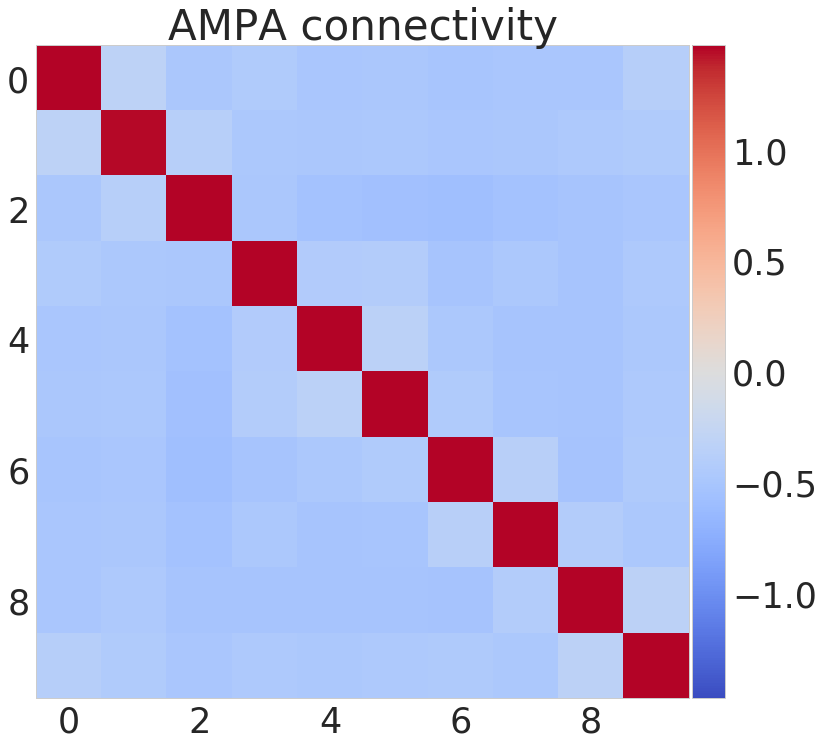

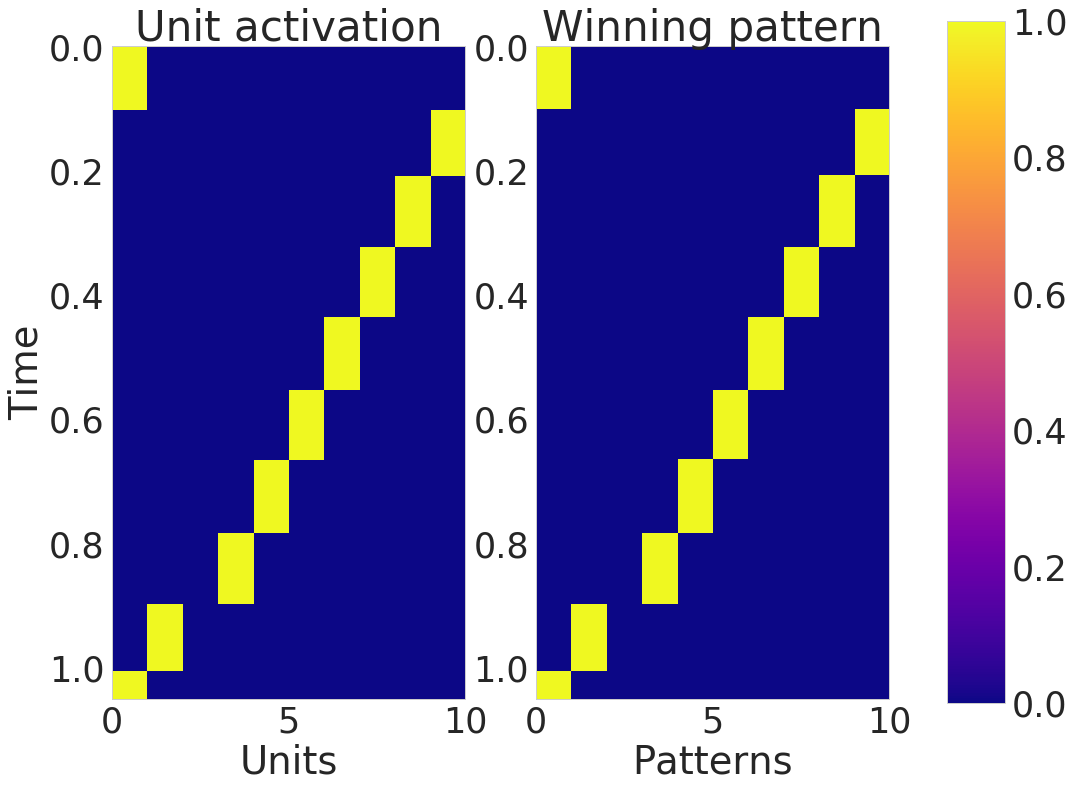

In [3]:
# Network structure
always_learning = True
k_perfect = True
perfect = True
strict_maximum = True
z_transfer = False

# First we run the training protocol
g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.1
tau_z_pre_ampa = 0.005
tau_z_post_ampa = 0.005
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 's']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
resting_time = 0.0
epochs = 3

# Build the network
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, sigma=sigma, G=G,
                  tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, 
                  z_transfer=z_transfer, diagonal_zero=False, strict_maximum=strict_maximum, perfect=perfect, 
                  k_perfect=k_perfect, always_learning=always_learning)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
protocol = Protocol()
patterns_indexes = [i for i in range(n_patterns)]
training_time = np.linspace(0.100, 1.0, num=n_patterns)[::-1]
# training_time = np.random.normal(loc=0.100, scale=0.010, size=n_patterns)
training_time = 0.100
protocol.simple_protocol(patterns_indexes, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                         inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Train
epoch_history = manager.run_network_protocol(protocol=protocol, verbose=True)

plot_weight_matrix(manager.nn, ampa=True)

T_recall = 1.0
T_cue = 0.050
nn.strict_maximum = True
sequences = [patterns_indexes]
I_cue = 0.0
n = 1

aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
total_sequence_time, mean, std, success, timings = aux
plot_network_activity_angle(manager)
print('success', success)

#### Without learning

w_diff 6.0
sigma 3.0
success 0.0


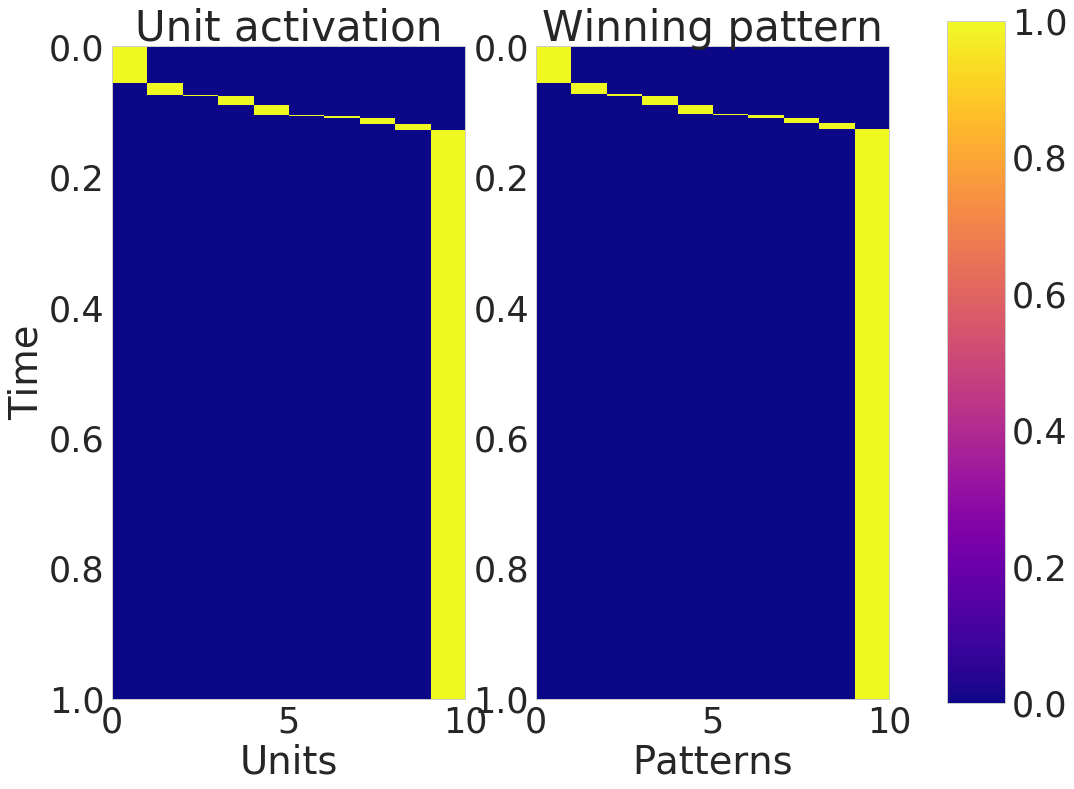

In [4]:
# Network structure
always_learning = True
k_perfect = True
perfect = True
strict_maximum = True
z_transfer = False

# First we run the training protocol
g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
g_I = 20.0
tau_a = 0.250
G = 1.0
sigma = 0.1
tau_z_pre_ampa = 0.005
tau_z_post_ampa = 0.005
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 's', 'i_ampa', 'i_nmda', 'beta', 'a']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
resting_time = 0.0
epochs = 3

# Network parameters
w_self = 1.0
w_next = -2
w_rest = -20
w_diff = g_w_ampa * (w_self  - w_next)
sigma = 0.5 * w_diff
print('w_diff', w_diff)
print('sigma', sigma)



# Build the network
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, sigma=sigma, G=G,
                  tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, g_I=g_I, 
                  z_transfer=z_transfer, diagonal_zero=False, strict_maximum=strict_maximum, perfect=perfect, 
                  k_perfect=k_perfect, always_learning=always_learning)
nn.g_beta = 0.0

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
w = simple_bcpnn_matrix(minicolumns, w_self, w_next, w_rest)
nn.w_ampa = w

# Recall
T_recall = 0.950
T_cue = 0.050
sequences = [[i for i in range(n_patterns)]]
n = 1

aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
total_sequence_time, mean, std, success, timings = aux
plot_network_activity_angle(manager)
print('success', success)

In [5]:
s = manager.history['s']
o = manager.history['o']
i_nmda = manager.history['i_nmda']
i_ampa = manager.history['i_ampa']
beta = manager.history['beta']
a = manager.history['a']

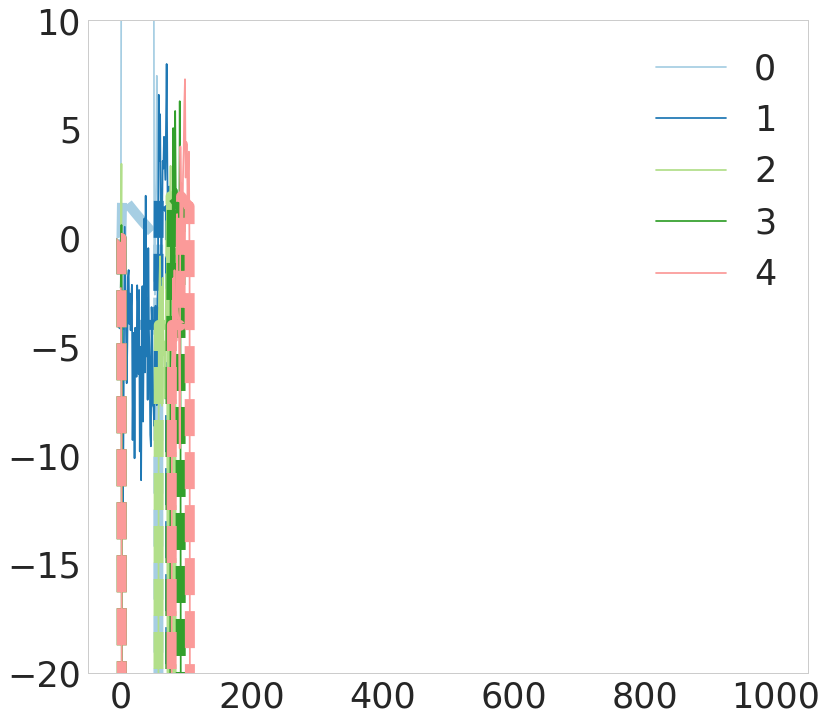

In [6]:
cmap = matplotlib.cm.Paired 
norm = matplotlib.colors.Normalize(vmin=0, vmax=n_patterns)

linewidth = 10

for index, (x1, x2, x3, x4) in enumerate(zip(s.T, i_ampa.T, a.T, beta.T)):
    # plt.plot(x2 - x3 + x4)
    if index < 5:
        plt.plot(x1, color=cmap(norm(index)), label=str(index))
        plt.plot(x2 - g_a * x3, ls='--', linewidth=linewidth, color=cmap(norm(index)))

plt.ylim([-20, 10])
plt.legend();

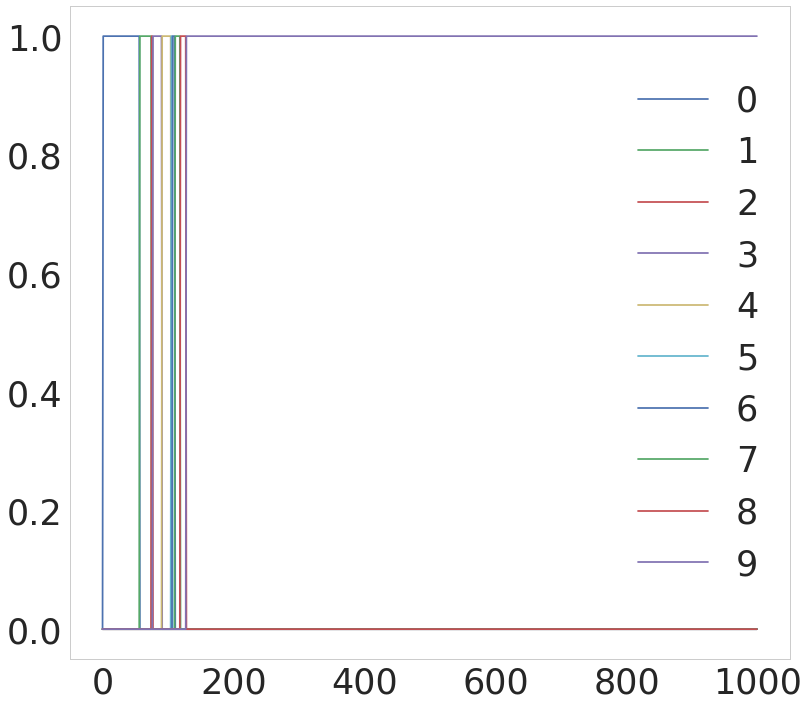

In [7]:
for index, unit in enumerate(o.T):
    plt.plot(unit, label=str(index))
    
plt.legend()

## Test recall vs noise
#### General parameters

In [19]:
# Network structure
always_learning = True
k_perfect = True
perfect = True
strict_maximum = True
z_transfer = False

# First we run the training protocol
g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.1
tau_z_pre_ampa = 0.005
tau_z_post_ampa = 0.005
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 's']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
resting_time = 0.0
epochs = 3

# Network parameters
w_self = 1.0
w_next = -2
w_rest = -4
w_diff = (w_self  - w_next)

w = simple_bcpnn_matrix(minicolumns, w_self, w_next, w_rest)

In [20]:
%%time
num = 10
trials = 10
sigma_vector = np.linspace(0, (g_w_ampa * w_diff)/2.0, num=num)
success_vector =  np.zeros((num, trials))
persistent_time_vector = np.zeros((num, trials))

for index_sigma, sigma in enumerate(sigma_vector):
    for trial in range(trials):
        # Build the network
        nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, sigma=sigma, G=G,
                          tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, 
                          z_transfer=z_transfer, diagonal_zero=False, strict_maximum=strict_maximum, perfect=perfect, 
                          k_perfect=k_perfect, always_learning=always_learning)

        # Build the manager
        manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
        nn.w_ampa = w

        # Recall
        T_recall = 2.2
        T_cue = 0.080
        sequences = [[i for i in range(n_patterns)]]
        n = 1

        aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
        total_sequence_time, mean, std, success, timings = aux

        success_vector[index_sigma, trial] = success
        persistent_time_vector[index_sigma, trial] = mean

CPU times: user 1min 3s, sys: 48 ms, total: 1min 3s
Wall time: 1min 3s


6.0


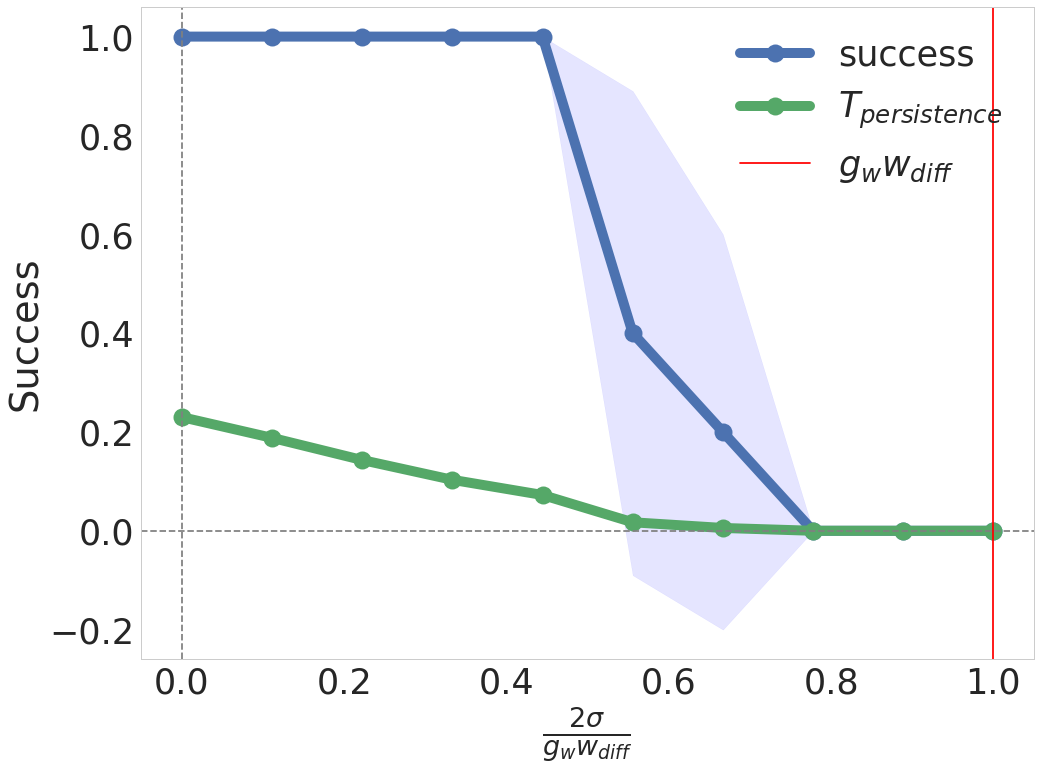

In [21]:
print(g_w_ampa * w_diff)

markersize = 18
linewidth = 10

successes = success_vector.mean(axis=1) / 100.0
success_first = np.copy(successes) * 100.0
std = success_vector.std(axis=1) / 100.0
normalized_sigma = (2 * sigma_vector) / (g_w_ampa * w_diff)
persistence =  persistent_time_vector.mean(axis=1)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(normalized_sigma, successes, 'o-', markersize=markersize, linewidth=linewidth, label='success')
ax.plot(normalized_sigma, persistence, 'o-', markersize=markersize, linewidth=linewidth, label=r'$T_{persistence}$')

ax.fill_between(normalized_sigma, successes - std, successes + std, color='blue', alpha=0.1)

ax.set_ylabel('Success')
ax.set_xlabel(r'$\frac{2 \sigma}{g_w w_{diff}}$')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')
ax.axvline(1, ls='-', color='red', label=r'$g_w w_{diff}$')

ax.legend();

In [11]:
%%time

# Network parameters
w_self = 1.0
w_next = 0.0
w_rest = -4
w_diff = g_w_ampa * (w_self  - w_next)

w = simple_bcpnn_matrix(minicolumns, w_self, w_next, w_rest)

num = 10
trials = 10
sigma_vector = np.linspace(0, w_diff /2.0, num=num)
success_vector =  np.zeros((num, trials))
persistent_time_vector = np.zeros((num, trials))

for index_sigma, sigma in enumerate(sigma_vector):
    for trial in range(trials):
        # Build the network
        nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, sigma=sigma, G=G,
                          tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, 
                          z_transfer=z_transfer, diagonal_zero=False, strict_maximum=strict_maximum, perfect=perfect, 
                          k_perfect=k_perfect, always_learning=always_learning)

        # Build the manager
        manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
        nn.w_ampa = w

        # Recall
        T_recall = 2.2
        T_cue = 0.080
        sequences = [[i for i in range(n_patterns)]]
        n = 1

        aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
        total_sequence_time, mean, std, success, timings = aux

        success_vector[index_sigma, trial] = success
        persistent_time_vector[index_sigma, trial] = mean

CPU times: user 1min 3s, sys: 24 ms, total: 1min 3s
Wall time: 1min 3s


2.0


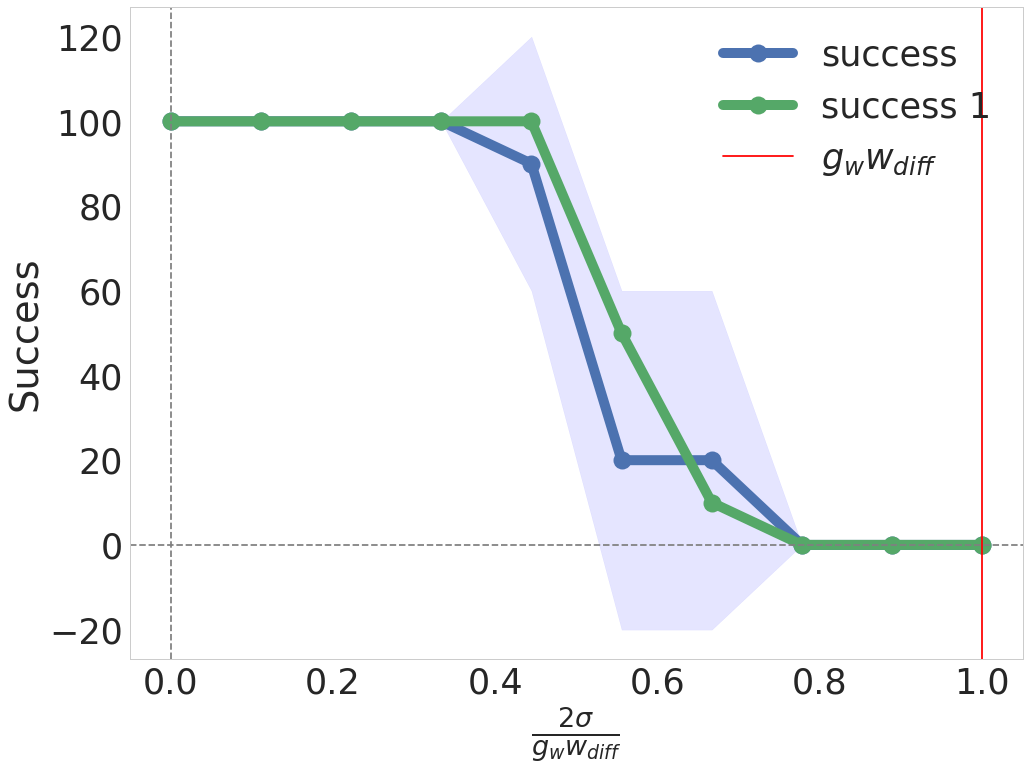

In [12]:
print(w_diff)

markersize = 18
linewidth = 10

successes = success_vector.mean(axis=1)
success_second = np.copy(successes)
std = success_vector.std(axis=1) 
normalized_sigma = (2 * sigma_vector) / w_diff
persistence =  persistent_time_vector.mean(axis=1)


fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(normalized_sigma, successes, 'o-', markersize=markersize, linewidth=linewidth, label='success')
ax.plot(normalized_sigma, success_first, 'o-', markersize=markersize, linewidth=linewidth, label='success 1')

ax.fill_between(normalized_sigma, successes - std, successes + std, color='blue', alpha=0.1)

ax.set_ylabel('Success')
ax.set_xlabel(r'$\frac{2 \sigma}{g_w w_{diff}}$')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')
ax.axvline(1, ls='-', color='red', label=r'$g_w w_{diff}$')

ax.legend();

In [13]:
%%time

# Network parameters
w_self = 1.0
w_next = 0.0
w_rest = -32.0
w_diff = g_w_ampa * (w_self  - w_next)

w = simple_bcpnn_matrix(minicolumns, w_self, w_next, w_rest)

num = 10
trials = 10
sigma_vector = np.linspace(0, w_diff /2.0, num=num)
success_vector = np.zeros((num, trials))
persistent_time_vector = np.zeros((num, trials))

for index_sigma, sigma in enumerate(sigma_vector):
    for trial in range(trials):
        # Build the network
        nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, sigma=sigma, G=G,
                          tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, 
                          z_transfer=z_transfer, diagonal_zero=False, strict_maximum=strict_maximum, perfect=perfect, 
                          k_perfect=k_perfect, always_learning=always_learning)

        # Build the manager
        manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
        nn.w_ampa = w

        # Recall
        T_recall = 2.2
        T_cue = 0.080
        sequences = [[i for i in range(n_patterns)]]
        n = 1

        aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
        total_sequence_time, mean, std, success, timings = aux

        success_vector[index_sigma, trial] = success
        persistent_time_vector[index_sigma, trial] = mean

CPU times: user 1min 2s, sys: 60 ms, total: 1min 2s
Wall time: 1min 2s


2.0


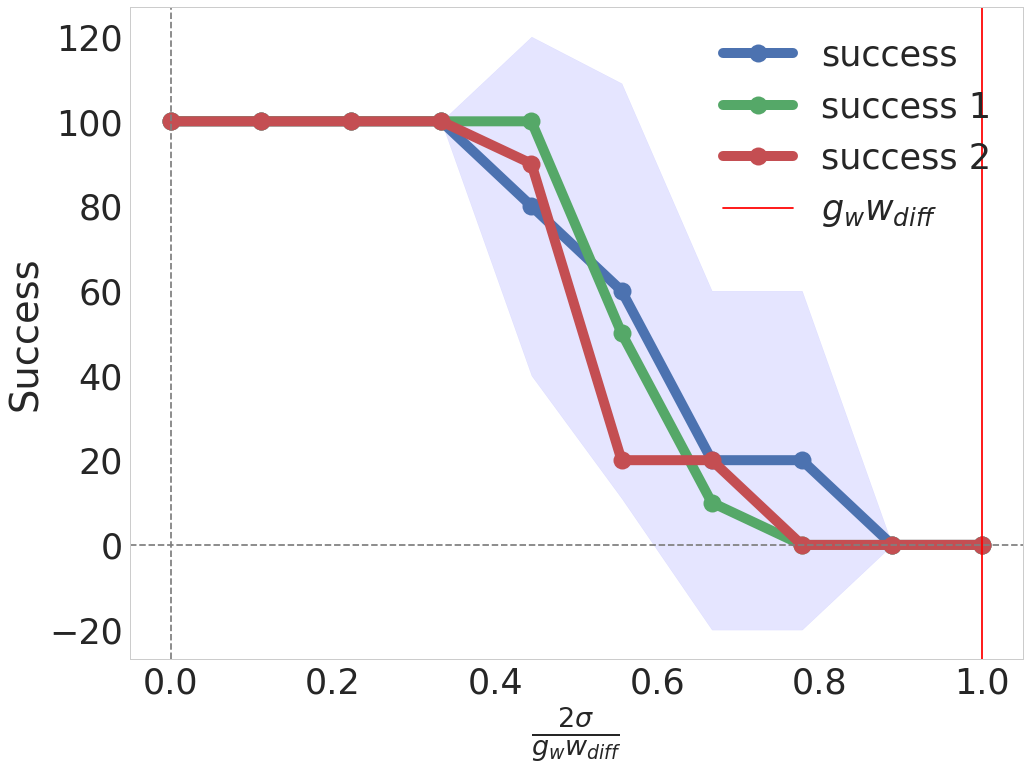

In [14]:
print(w_diff)

markersize = 18
linewidth = 10

successes = success_vector.mean(axis=1) 
std = success_vector.std(axis=1) 
normalized_sigma = (2 * sigma_vector) / w_diff
persistence =  persistent_time_vector.mean(axis=1)


fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(normalized_sigma, successes, 'o-', markersize=markersize, linewidth=linewidth, label='success')
ax.plot(normalized_sigma, success_first, 'o-', markersize=markersize, linewidth=linewidth, label='success 1')
ax.plot(normalized_sigma, success_second, 'o-', markersize=markersize, linewidth=linewidth, label='success 2')


ax.fill_between(normalized_sigma, successes - std, successes + std, color='blue', alpha=0.1)

ax.set_ylabel('Success')
ax.set_xlabel(r'$\frac{2 \sigma}{g_w w_{diff}}$')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')
ax.axvline(1, ls='-', color='red', label=r'$g_w w_{diff}$')

ax.legend();

## Noise vs length of the chain

In [15]:
# Network structure
always_learning = True
k_perfect = True
perfect = True
strict_maximum = True
z_transfer = False

# First we run the training protocol
g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.1
tau_z_pre_ampa = 0.005
tau_z_post_ampa = 0.005
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 's']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
resting_time = 0.0
epochs = 3

# Network parameters
w_self = 1.0
w_next = -1.0
w_rest = -4
w_diff = g_w_ampa * (w_self  - w_next)



In [16]:
%%time
num = 20
trials = 15
sigma_vector = np.linspace(0, w_diff/2.0, num=num)
success_list = []
persistent_list = []
minicolumns_vector = np.arange(10, 60, 10.0, dtype='int')

for minicolumns_ in minicolumns_vector:
    print(minicolumns_)
    success_vector =  np.zeros((num, trials))
    persistent_time_vector = np.zeros((num, trials))

    for index_sigma, sigma in enumerate(sigma_vector):
        for trial in range(trials):
            # Build the network
            nn = BCPNNPerfect(hypercolumns, minicolumns_, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, sigma=sigma, G=G,
                              tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, 
                              z_transfer=z_transfer, diagonal_zero=False, strict_maximum=strict_maximum, perfect=perfect, 
                              k_perfect=k_perfect, always_learning=always_learning)

            # Build the manager
            manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
            w = simple_bcpnn_matrix(minicolumns_, w_self, w_next, w_rest)
            nn.w_ampa = w

            # Recall
            T_recall = 3.0
            T_cue = 0.050
            sequences = [[i for i in range(minicolumns_)]]
            n = 1

            aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
            total_sequence_time, mean, std, success, timings = aux

            success_vector[index_sigma, trial] = success
            persistent_time_vector[index_sigma, trial] = mean
            
    success_list.append(success_vector)
    persistent_list.append(persistent_time_vector)

10
20
30
40
50


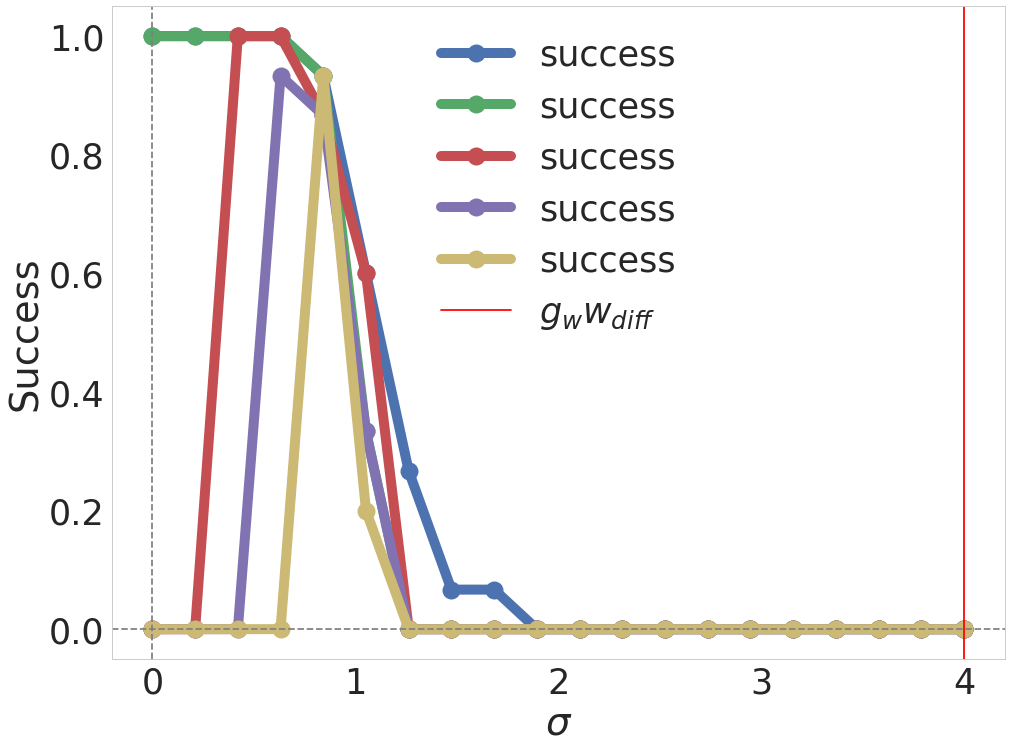

In [17]:
markersize = 18
linewidth = 10

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for success_vector in success_list:

    successes = success_vector.mean(axis=1) / 100.0
    std = success_vector.std(axis=1) / 100.0
    persistence =  persistent_time_vector.mean(axis=1)
    ax.plot(sigma_vector, successes, 'o-', markersize=markersize, linewidth=linewidth, label='success')

# ax.fill_between(sigma_vector, successes - std, successes + std, color='blue', alpha=0.1)

ax.set_ylabel('Success')
ax.set_xlabel(r'$\sigma$')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')
ax.axvline(w_diff, ls='-', color='red', label=r'$g_w w_{diff}$')

ax.legend();